## Предсказание стоимости жилья



В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

**Цель проекта:**
В проекте  необходимо обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве — median_house_value. Обучить модель и сделать предсказания на тестовой выборке. Для оценки качества модели использовать метрики RMSE, MAE и R2.

**План выполнения проекта:**
 - Инициализировать локальную Spark-сессию.
 - Прочитать содержимое файла /datasets/housing.csv.
 - Вывести типы данных колонок датасета. Использовать методы pySpark.
 - Выполнить предобработку данных:
 - Исследовать данные на наличие пропусков и заполнить их, выбрав значения по своему усмотрению.
 - Преобразовать колонку с категориальными значениями техникой One hot encoding.
 - Построить две модели линейной регрессии на разных наборах данных:
   - используя все данные из файла;
   - используя только числовые переменные, исключив категориальные.
 - Для построения модели использовать оценщик LinearRegression из библиотеки MLlib.
 - Сравнить результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2. Сделать выводы.

# Подготовка данных

Импортируем нужные библиотеки

In [1]:
import pandas as pd 
import numpy as np
import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import concat,col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder 
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.image as mpimg  
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
RANDOM_SEED = 12345

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Инициализируем локальную Spark-сессию

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

log4j:ERROR Could not read configuration file from URL [file:/opt/conda/lib/python3.9/site-packages/pyspark/conf/log4j.properties].
java.io.FileNotFoundException: /opt/conda/lib/python3.9/site-packages/pyspark/conf/log4j.properties (Permission denied)
	at java.io.FileInputStream.open0(Native Method)
	at java.io.FileInputStream.open(FileInputStream.java:195)
	at java.io.FileInputStream.<init>(FileInputStream.java:138)
	at java.io.FileInputStream.<init>(FileInputStream.java:93)
	at sun.net.www.protocol.file.FileURLConnection.connect(FileURLConnection.java:90)
	at sun.net.www.protocol.file.FileURLConnection.getInputStream(FileURLConnection.java:188)
	at org.apache.log4j.PropertyConfigurator.doConfigure(PropertyConfigurator.java:557)
	at org.apache.log4j.helpers.OptionConverter.selectAndConfigure(OptionConverter.java:526)
	at org.apache.log4j.LogManager.<clinit>(LogManager.java:127)
	at org.slf4j.impl.Log4jLoggerFactory.<init>(Log4jLoggerFactory.java:66)
	at org.slf4j.impl.StaticLoggerBind

In [3]:
df_housing = spark.read.load('/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Выведем типы данных колонок датасета. Используем для этого метод pySpark dtypes:

In [4]:
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


В большинстве колонок хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения.

Выведем 5 строк полученного датафрейма

In [5]:
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Представим результат в виде таблицы pandas. Выведем с помощью метода describe() базовые описательные статистики.

In [6]:
df_housing.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [7]:

df_housing.describe().show(vertical=True)

-RECORD 0---------------------------------
 summary            | count               
 longitude          | 20640               
 latitude           | 20640               
 housing_median_age | 20640               
 total_rooms        | 20640               
 total_bedrooms     | 20433               
 population         | 20640               
 households         | 20640               
 median_income      | 20640               
 median_house_value | 20640               
 ocean_proximity    | 20640               
-RECORD 1---------------------------------
 summary            | mean                
 longitude          | -119.56970445736148 
 latitude           | 35.6318614341087    
 housing_median_age | 28.639486434108527  
 total_rooms        | 2635.7630813953488  
 total_bedrooms     | 537.8705525375618   
 population         | 1425.4767441860465  
 households         | 499.5396802325581   
 median_income      | 3.8706710029070246  
 median_house_value | 206855.81690891474  
 ocean_prox

Проверим, есть ли пропущенные значения в датасете. Найдём их количество в каждой колонке.

In [8]:
columns = df_housing.columns

for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Столбец `total_bedrooms` имеет 207 пропущенных значений. Заменим пропущенные значения средним.

In [9]:
mean_total_bedrooms = df_housing.select(F.mean('total_bedrooms')).collect()[0][0]
print('Среднее значение колонки total_bedrooms:', mean_total_bedrooms)

Среднее значение колонки total_bedrooms: 537.8705525375618


In [10]:
df = df_housing.na.fill({'total_bedrooms': mean_total_bedrooms})
df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.870553,419.266592,1.0000,297.0000,438.0000,643.25000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000



Визуализируем жилые массивы, в которых живут самые обеспеченные люди

<AxesSubplot:xlabel='ocean_proximity', ylabel='avg(median_income)'>

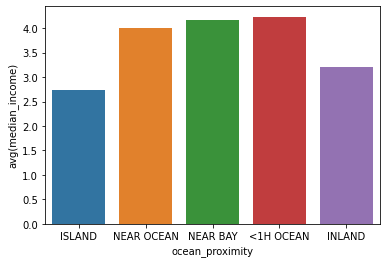

In [11]:
df_wealthy = df_housing.groupBy('ocean_proximity').agg(F.avg('median_income')).toPandas()
sns.barplot(x=df_wealthy['ocean_proximity'], y=df_wealthy['avg(median_income)'])

Ожидаемый результат: люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.


Посмотрим на карту расположения домов в жилых массивах по их стоимости

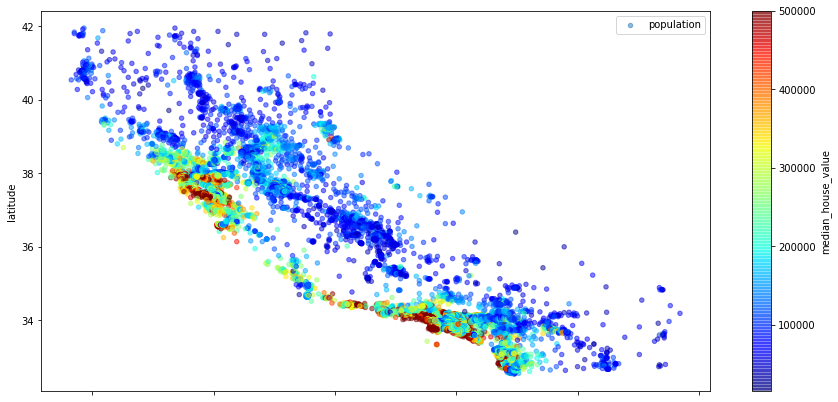

In [12]:
df_h = df.toPandas()
df_h.plot(kind='scatter', x="longitude", y="latitude", figsize=(15,7), alpha=0.5,
          label="population", c="median_house_value",
         cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend(loc="best")
plt.show()

Вспоминая урок географии и расположение Калифорнии на глобусе, можно смело сказать, и это подтверждает наш график, что самые дорогие дома находятся на побережье океана.

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

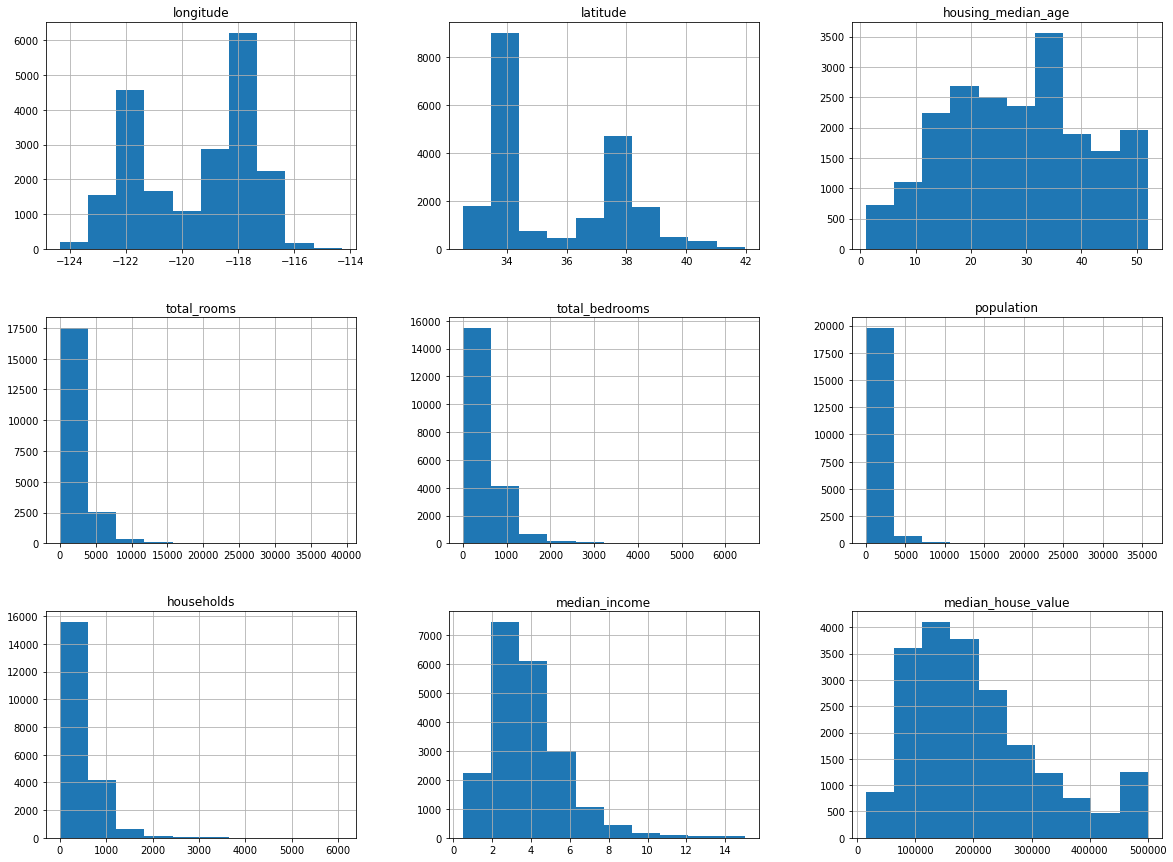

In [13]:
df_h.hist(figsize=(20,15))

Исходя из гистограмм следует, что только столбец ` housing_median_age` распределен нормально, остальные все искажены вправо

Построим корреляционную матрицу, предварительно удалив категориальный столбец и преобразуя данные в векторный вид

In [14]:
df_h_num = df.drop('ocean_proximity')
columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']
assembler = VectorAssembler(
    inputCols=columns,
    outputCol="features")
df_h_vector = assembler.transform(df_h_num)
matrix = Correlation.corr(df_h_vector, 'features').collect()[0][0]
corrmatrix = matrix.toArray().tolist()


22/05/28 07:25:19 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/28 07:25:19 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


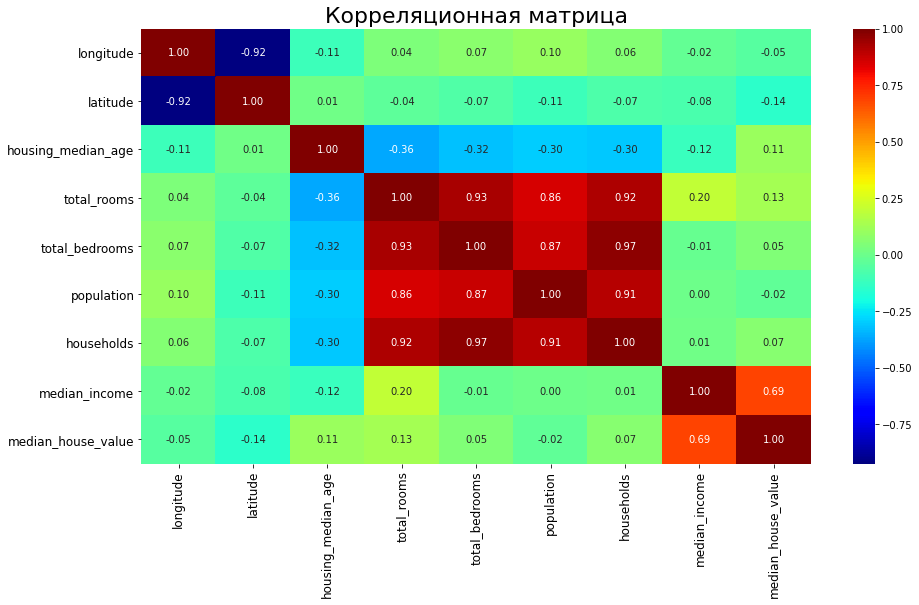

In [15]:
plt.figure(figsize=(15, 8))
sns.heatmap(corrmatrix, annot=True, fmt='0.2f', annot_kws={
    'size': 10}, cmap=plt.get_cmap("jet"), xticklabels=df_h_num.columns, yticklabels=df_h_num.columns)
plt.title('Корреляционная матрица', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Корреляционная матрица ярко выделяет высокую коллинеарность между `households` и `total_bedrooms`, а также `households` и `total_rooms`, `households` и `population`. Так как эти переменные сильно коррелированы, создадим новые столбцы с их соотношением, чтобы коллинеарность не  играла существенную роль в наших моделях, но они важны, поскольку они обычно влияют на ценообразование домов. 

Создадим несколько новых столбцов с признаками: 

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Назовём столбец `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Назовём столбец `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Назовём столбец `bedroom_index`.

In [16]:
df = df.withColumn('rooms_per_household', F.col('total_rooms')/F.col('households'))\
.withColumn('population_in_household', F.col('population')/F.col('households'))\
.withColumn('bedroom_index', F.col('total_bedrooms')/F.col('total_rooms'))

df.toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_in_household,bedroom_index
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556,0.146591
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842,0.155797
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,2.802260,0.129516
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945,0.184458
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467,0.172096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,5.045455,2.560606,0.224625
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,6.114035,3.122807,0.215208
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,5.205543,2.325635,0.215173
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,5.329513,2.123209,0.219892


Удалим такие столбцы, как `longitude`, `latitude`, `total_rooms`, `total_bedrooms`, `population`. Для дальнейшего анализа они не понадобятся. Используем метод select() для выбора и изменения порядка необходимых столбцов в фрейме данных.

In [17]:
df.columns


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'rooms_per_household',
 'population_in_household',
 'bedroom_index']

In [18]:
df = df.select('median_house_value', 'housing_median_age',  
               'households', 'median_income', 'ocean_proximity', 'rooms_per_household', 'population_in_household',
               'bedroom_index')

In [19]:
df.toPandas()

,median_house_value,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,population_in_household,bedroom_index
0,452600.0,41.0,126.0,8.3252,NEAR BAY,6.984127,2.555556,0.146591
1,358500.0,21.0,1138.0,8.3014,NEAR BAY,6.238137,2.109842,0.155797
2,352100.0,52.0,177.0,7.2574,NEAR BAY,8.288136,2.802260,0.129516
3,341300.0,52.0,219.0,5.6431,NEAR BAY,5.817352,2.547945,0.184458
4,342200.0,52.0,259.0,3.8462,NEAR BAY,6.281853,2.181467,0.172096
...,...,...,...,...,...,...,...,...
20635,78100.0,25.0,330.0,1.5603,INLAND,5.045455,2.560606,0.224625
20636,77100.0,18.0,114.0,2.5568,INLAND,6.114035,3.122807,0.215208
20637,92300.0,17.0,433.0,1.7000,INLAND,5.205543,2.325635,0.215173
20638,84700.0,18.0,349.0,1.8672,INLAND,5.329513,2.123209,0.219892


**Преобразование категориальных значений**

Преобразуем столбец `ocean_proximity` с категориальными значениями техникой StringIndexer и One hot encoding.
Сначала трансформируем категориальные признаки в числовое представление с помощью трансформера StringIndexer

In [20]:
categorical_cols = ['ocean_proximity']

In [21]:
indexer = StringIndexer(inputCol='ocean_proximity',
                        outputCol='ocean_proximity_idx')
df_idx = indexer.fit(df).transform(df)
df_idx = df_idx.drop('ocean_proximity')

Далее выполним OHE-кодирование для категорий

In [22]:
encoder = OneHotEncoder(inputCol='ocean_proximity_idx',
                        outputCol='ocean_proximity_ohe')
df_ohe = encoder.fit(df_idx)
df_ohe = df_ohe.transform(df_idx)

In [23]:
df_ohe.toPandas().head()

,median_house_value,housing_median_age,households,median_income,rooms_per_household,population_in_household,bedroom_index,ocean_proximity_idx,ocean_proximity_ohe
0,452600.0,41.0,126.0,8.3252,6.984127,2.555556,0.146591,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,358500.0,21.0,1138.0,8.3014,6.238137,2.109842,0.155797,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,352100.0,52.0,177.0,7.2574,8.288136,2.802260,0.129516,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,341300.0,52.0,219.0,5.6431,5.817352,2.547945,0.184458,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,342200.0,52.0,259.0,3.8462,6.281853,2.181467,0.172096,3.0,"(0.0, 0.0, 0.0, 1.0)"


Объединим признаки в один вектор с помощью VectorAssembler

In [24]:
categorical_cols = ['ocean_proximity_ohe']
categorical_assembler = VectorAssembler(inputCols=categorical_cols, outputCol="categorical_features")
df = categorical_assembler.transform(df_ohe)

**Преобразование числовых признаков**

In [25]:
numerical_cols = ['housing_median_age',  
               'households', 'median_income', 'rooms_per_household', 'population_in_household',
               'bedroom_index']
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
df = numerical_assembler.transform(df) 

In [26]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
df = standardScaler.fit(df).transform(df) 

In [27]:
df.toPandas().head()

,median_house_value,housing_median_age,households,median_income,rooms_per_household,population_in_household,bedroom_index,ocean_proximity_idx,ocean_proximity_ohe,categorical_features,numerical_features,numerical_features_scaled
0,452600.0,41.0,126.0,8.3252,6.984127,2.555556,0.146591,3.0,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","[41.0, 126.0, 8.3252, 6.984126984126984, 2.555...","[3.2577023016083064, 0.3295584480852433, 4.382..."
1,358500.0,21.0,1138.0,8.3014,6.238137,2.109842,0.155797,3.0,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","[21.0, 1138.0, 8.3014, 6.238137082601054, 2.10...","[1.668579227653035, 2.9764882057222772, 4.3695..."
2,352100.0,52.0,177.0,7.2574,8.288136,2.802260,0.129516,3.0,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","[52.0, 177.0, 7.2574, 8.288135593220339, 2.802...","[4.131719992283705, 0.4629511532626037, 3.8200..."
3,341300.0,52.0,219.0,5.6431,5.817352,2.547945,0.184458,3.0,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","[52.0, 219.0, 5.6431, 5.8173515981735155, 2.54...","[4.131719992283705, 0.5728039692910182, 2.9703..."
4,342200.0,52.0,259.0,3.8462,6.281853,2.181467,0.172096,3.0,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)","[52.0, 259.0, 3.8462, 6.281853281853282, 2.181...","[4.131719992283705, 0.6774256988418891, 2.0245..."


Так как обучение модели будем проводить на двух группах признаков: все признаки и только числовые, соберем полученные категорийные и числовые признаки с помощью VectorAssembler

In [28]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 
df = final_assembler.transform(df)

In [29]:
df.select(all_features).show(3)

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[3],[1.0])|     [3.25770230160830...|
|       (4,[3],[1.0])|     [1.66857922765303...|
|       (4,[3],[1.0])|     [4.13171999228370...|
+--------------------+-------------------------+
only showing top 3 rows



**Вывод**


При подготовке данных выяснили, что в датасете  20640 строк.

Столбец `ocean_proximity` имеет тип данных - str  с категориальными значениями. Все остальные столбцы хранят количественные данные и имеют тип данных - float. 

Столбец `total_bedrooms` имел пропущенные значения, заменили их на среднее. 

Создали три новых столбца, заменив их на сильно коррелирующие удаленные столбцы `total_rooms`, `total_bedrooms`, `population`. Также удалили столбцы с данными о широте и долготе, т.к. они малозначимы для построения моделей. 

Преобразовали столбцы с категориальными значениями и числовыми с помощью базовых трансформеров признаков — StringIndexer и OneHotEncoder. Объединили признаки в один вектор с помощью VectorAssembler.

Визуально увидели, что люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива. Соответственно, и стоимость домов в жилых массивах значительно выше, чем вглубь Калифорнии.

Столбец `housing_median_age` единственный распределен нормально, остальные все искажены вправо.

# Обучение моделей

Присвоим целевому признаку значение переменной target

После завершения всей предварительной обработки приступим к построению нашей модели линейной регрессии. Сначала разделим данные на обучающие и тестовые наборы  с помощью метода randomSplit()

Присвоим целевому признаку значение переменной target

In [30]:
target = "median_house_value" 

In [31]:
train, test = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print('Количество объектов в обучающей выборке:', train.count())
print('Количество объектов в тестовой выборке:', test.count())

Количество объектов в обучающей выборке: 16431
Количество объектов в тестовой выборке: 4209


Первая модель линейной регрессии будет использовать все данные

In [32]:
lr_1 = LinearRegression(labelCol=target, featuresCol='features', predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False)

In [33]:
lr_all_features = lr_1.fit(train)

Сохраним трансформированную таблицу с колонкой предсказания первой модели в переменной `predictions`

In [34]:
predictions = lr_all_features.transform(test)

Извлечем предсказания и целевой признак

In [35]:
predandlabels = predictions.select("predmedhv", target)
predandlabels.show()

+------------------+------------------+
|         predmedhv|median_house_value|
+------------------+------------------+
| 183848.3670792777|           22500.0|
| 71380.71196307341|           34600.0|
|138250.17863214947|           35000.0|
|162453.90539968316|           37500.0|
| 60824.08915600174|           39400.0|
|119856.42064673093|           41300.0|
| 48492.21375435353|           41700.0|
|  73992.1066902338|           43000.0|
| 85750.38524202286|           44800.0|
|173889.98731819325|           45000.0|
| 62586.25766265536|           45000.0|
| 44914.59712734589|           46500.0|
|61633.481857174695|           46700.0|
|   66535.866472981|           46700.0|
|64959.027550942534|           46900.0|
| 51892.99966153394|           47000.0|
| 49272.01523806477|           47100.0|
| 72946.72047682616|           47500.0|
| 73531.94645842619|           47500.0|
| 77644.29928399067|           47500.0|
+------------------+------------------+
only showing top 20 rows



Аналогично построим и обучим вторую модель, но используя только числовые переменные, исключив категориальные

In [36]:
lr_2 = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled', predictionCol='predmedhv_num', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False)

In [37]:
lr_numerical_features = lr_2.fit(train)

In [38]:
predictions_num = lr_numerical_features.transform(test)

In [39]:
predandlabels_num = predictions_num.select("predmedhv_num", target)
predandlabels_num.show()

+------------------+------------------+
|     predmedhv_num|median_house_value|
+------------------+------------------+
|  150562.571328439|           22500.0|
| 96612.31817162407|           34600.0|
|193840.47113950542|           35000.0|
|112971.66226189907|           37500.0|
| 96771.86891975041|           39400.0|
| 145588.5155685932|           41300.0|
| 83375.12873089378|           41700.0|
|119253.22681438658|           43000.0|
| 134818.6733585835|           44800.0|
|148006.30605598298|           45000.0|
|111528.24624013333|           45000.0|
| 73597.48452690983|           46500.0|
| 95633.81298534592|           46700.0|
|102786.18676641711|           46700.0|
|106292.44979144362|           46900.0|
| 85001.78538958592|           47000.0|
|  86069.6470607442|           47100.0|
|108032.57141397314|           47500.0|
| 112067.1834388625|           47500.0|
|124360.66696991396|           47500.0|
+------------------+------------------+
only showing top 20 rows



**Вывод**

Получили предсказание `median_house_value` медианной стоимости дома, используя все данные датасета и  только на числовых признаках. Сравнивая две таблицы предсказаний, видно, что предсказания, сделанные на числовых переменных, ниже.

# Анализ результатов

Смотреть на прогнозируемые значения - это одно, но другое и лучшее - это смотреть на некоторые показатели, чтобы получить лучшее представление о том, насколько хороши модели на самом деле.

Для оценки  качества модели используем RegressionEvaluator. 

Сравним результаты работы линейной регрессии на двух наборах данных по следующим метрикам:
- Корень от средней квадратической ошибки - **RMSE**. В свою очередь средняя квадратическая ошибка - это величина равная сумме квадратов отклонений (разница между предсказанием и фактической величиной целевого признака), разделенной на количество объектов. Чем точнее модель, тем больше значение RMSE будет стремиться к нулю.
- Среднее абсолютное значение или **MAE** - это величина, равная сумме всех модулей отклонений (разница между предсказанием и фактическим значением целевого признака), разделенная на количество объектов в выборке. Соответственно, для модели, которая идеально работает, MAE будет равен 0. Поэтому, чем меньше будет значение этой метрики, тем точнее модель.
- **R2**("R squared") или коэффициент детерминации - это показатель, который показывает, насколько данные близки к установленной линии регрессии. Этот показатель всегда будет находиться в диапазоне от 0 до 100% (или в данном случае от 0 до 1), где 0% указывает на то, что модель не объясняет ни одной изменчивости данных ответов относительно ее среднего значения, а 100% указывает на обратное: она объясняет всю изменчивость. Это означает, что, как правило, чем выше R-squared, тем лучше модель соответствует нашим данным.

**На всех признаках**

In [40]:
evaluator = RegressionEvaluator(predictionCol='predmedhv',
                                labelCol=target)
RMSE_1 = evaluator.evaluate(predandlabels, {evaluator.metricName: "rmse"})

In [41]:

MAE_1 = evaluator.evaluate(predandlabels, {evaluator.metricName: "mae"})

In [42]:
R2_1 = evaluator.evaluate(predandlabels, {evaluator.metricName: "r2"})

In [43]:
cols = ["MODEL","RMSE","MAE", "R-SQUARE"]
model_report1 = pd.DataFrame(columns = cols)

tmp1 = pd.Series({ "MODEL" : "lr_all_features",
                  "RMSE" : RMSE_1,
                  "MAE" : MAE_1,
                  "R-SQUARE" : R2_1})
model_lr1_report = model_report1.append(tmp1, ignore_index=True)
model_lr1_report

,MODEL,RMSE,MAE,R-SQUARE
0,lr_all_features,72185.523291,52340.53258,0.613988


**Только на числовых признаках**

In [44]:
evaluator = RegressionEvaluator(predictionCol='predmedhv_num',
                                labelCol=target)
RMSE_2 = evaluator.evaluate(predandlabels_num, {evaluator.metricName: "rmse"})
MAE_2 = evaluator.evaluate(predandlabels_num, {evaluator.metricName: "mae"})
R2_2 = evaluator.evaluate(predandlabels_num, {evaluator.metricName: "r2"})

In [45]:
cols = ["MODEL","RMSE","MAE", "R-SQUARE"]
model_report2 = pd.DataFrame(columns = cols)

tmp2 = pd.Series({ "MODEL" : "lr_numerical_features",
                  "RMSE" : RMSE_2,
                  "MAE" : MAE_2,
                  "R-SQUARE" : R2_2})
model_lr2_report = model_report2.append(tmp2, ignore_index=True)
model_lr2_report

,MODEL,RMSE,MAE,R-SQUARE
0,lr_numerical_features,78024.679632,57907.231033,0.549012


**Вывод** 

Как видим, согласно значениям  всех метрик первая модель, обученная на всех признаках, работает точнее.

# Общий вывод

In [46]:
cols = ["MODEL","RMSE","MAE", "R-SQUARE"]
model_report = pd.DataFrame(columns = cols)
final_report = pd.concat([model_lr1_report, model_lr2_report], ignore_index=True)
final_report

,MODEL,RMSE,MAE,R-SQUARE
0,lr_all_features,72185.523291,52340.532580,0.613988
1,lr_numerical_features,78024.679632,57907.231033,0.549012


Целью данного проекта была необходимость обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году.
В ходе работы инициализировали локальную Spark-сессию, провели предобработку данных, используя методы pySpark,исследовали данные на наличие пропусков и избавились от них, заменив пропущенные значения на среднее.

Преобразовали колонку с категориальными значениями техникой One hot encoding.

Провели стандартизацию количественных признаков.

Построили две модели линейной регрессии на разных наборах данных:

 - используя все данные из файла;
 - используя только числовые переменные, исключив категориальные.

На основе данных  из двух наборов предсказали медианную стоимость дома в жилом массиве — median_house_value.  Для оценки качества модели использовали метрики RMSE, MAE и R2.
 Лучшей показала себя модель, обученная на всех признаках. Это видно из сводной таблицы. В процентном соотношении разница составила всего 0,05%.
 

In [47]:
spark.stop()